<a href="https://colab.research.google.com/github/hsaripalli/Bitcoin/blob/main/BTC_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Reference for the code: 
# https://www.youtube.com/watch?v=H6du_pfuznE&ab_channel=KrishNaik

In [ ]:
pip install yfinance

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math

In [ ]:
btc = yf.download('BTC-USD')
btc

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2022-01-26,36950.515625,38825.410156,36374.906250,36852.121094,36852.121094,31324598034
2022-01-27,36841.878906,37148.324219,35629.281250,37138.234375,37138.234375,25041426629
2022-01-28,37128.445312,37952.878906,36211.109375,37784.332031,37784.332031,22238830523


In [ ]:
btc = btc.tail(1095)
btc = btc.reset_index()['Adj Close']
btc

0        3487.945312
1        3521.060791
2        3464.013428
3        3459.154053
4        3466.357422
            ...     
1090    36852.121094
1091    37138.234375
1092    37784.332031
1093    38138.179688
1094    37946.878906
Name: Adj Close, Length: 1095, dtype: float64

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
scaled_btc = scaler.fit_transform(np.array(btc).reshape(-1,1))

In [ ]:
scaled_btc.shape

(1095, 1)

In [ ]:
train_size = int(len(scaled_btc)*0.8)
test_size = len(scaled_btc)-train_size
train_data, test_data = scaled_btc[0:train_size,:], scaled_btc[train_size:len(scaled_btc),:1]

In [ ]:
def create_dataset(dataset, time_step = 1):
  dataX, dataY = [],[]
  for i in range(len(dataset) - time_step-1):
    a = dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i+time_step,0])
  return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape), print(y_train.shape)

(775, 100)
(775,)


(None, None)

In [ ]:
print(X_test.shape), print(y_test.shape)

(118, 100)
(118,)


(None, None)

In [ ]:
# reshape input to 3D fpr LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
print(X_train.shape), print(X_test.shape)

(775, 100, 1)
(118, 100, 1)


(None, None)

In [ ]:
# Create stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
13/13 [==============================] - 17s 579ms/step - loss: 0.0355 - val_loss: 0.0469
Epoch 2/100
13/13 [==============================] - 5s 398ms/step - loss: 0.0061 - val_loss: 0.0076
Epoch 3/100
13/13 [==============================] - 5s 379ms/step - loss: 0.0037 - val_loss: 0.0132
Epoch 4/100
13/13 [==============================] - 5s 388ms/step - loss: 0.0030 - val_loss: 0.0069
Epoch 5/100
13/13 [==============================] - 5s 342ms/step - loss: 0.0024 - val_loss: 0.0073
Epoch 6/100
13/13 [==============================] - 4s 337ms/step - loss: 0.0023 - val_loss: 0.0062
Epoch 7/100
13/13 [==============================] - 3s 207ms/step - loss: 0.0021 - val_loss: 0.0061
Epoch 8/100
13/13 [==============================] - 2s 192ms/step - loss: 0.0020 - val_loss: 0.0068
Epoch 9/100
13/13 [==============================] - 3s 200ms/step - loss: 0.0020 - val_loss: 0.0054
Epoch 10/100
13/13 [==============================] - 3s 197ms/step - loss: 0.0020 - val_l

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [ ]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

0.019185238020965573

In [ ]:
math.sqrt(mean_squared_error(y_test, test_predict))

0.03438839708755553

In [ ]:
math.sqrt(mean_squared_error(scaler.inverse_transform(y_train.reshape(-1,1)), scaler.inverse_transform(train_predict.reshape(-1,1))))

1231.0660180934833

In [ ]:
math.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)), scaler.inverse_transform(test_predict.reshape(-1,1))))

2206.6123857620473

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(scaler.inverse_transform(y_test.reshape(-1,1)), scaler.inverse_transform(test_predict.reshape(-1,1)))

1702.2809189618645

In [ ]:
mean_absolute_error(scaler.inverse_transform(y_train.reshape(-1,1)), scaler.inverse_transform(train_predict.reshape(-1,1)))

755.1479889112903

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test, test_predict)

0.9325775873246148

In [ ]:
r2_score(y_train, train_predict)

0.9941381074208147

In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

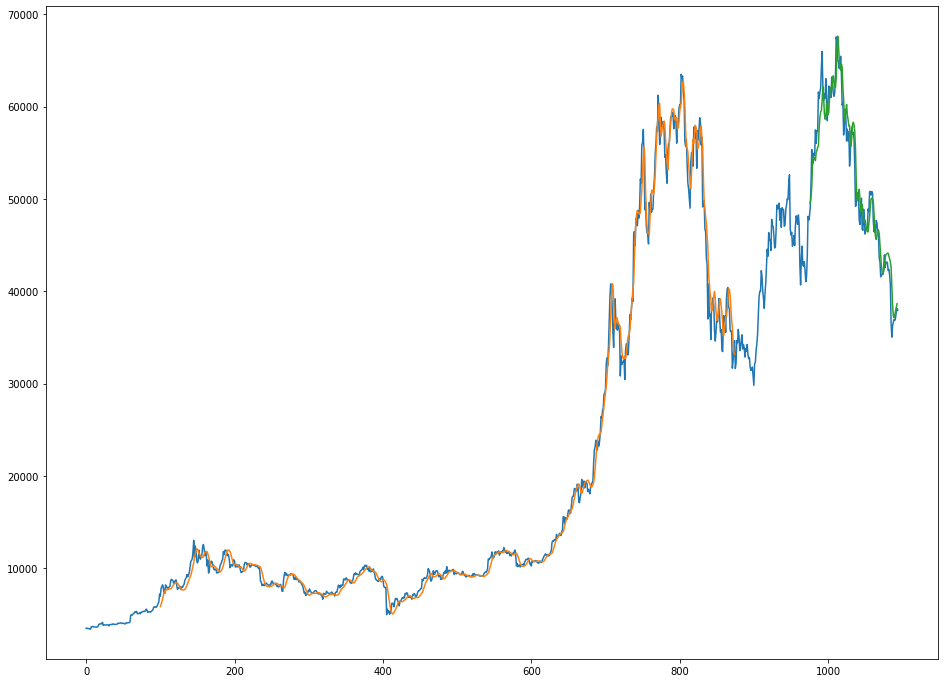

In [ ]:
look_back = 100
trainPredictPlot = np.empty_like(scaled_btc)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back,:] = train_predict

testPredictPlot = np.empty_like(scaled_btc)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back*2) + 1:len(scaled_btc) - 1,:] = test_predict

plt.figure(figsize=(16,12))
plt.plot(scaler.inverse_transform(scaled_btc))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
len(test_data)

219

In [ ]:
x_input=test_data[len(test_data)-100:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
# demonstrate prediction for next 30 days

lst_output=[]
n_steps=100
i=0
while(i<10):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.5602886]
101
1 day output [[0.5684657]]
2 day output [[0.5789196]]
3 day output [[0.59025216]]
4 day output [[0.60183907]]
5 day output [[0.61336464]]
6 day output [[0.6245839]]
7 day output [[0.63525856]]
8 day output [[0.64514905]]
9 day output [[0.6540283]]
[[0.5602886080741882], [0.5684657096862793], [0.5789195895195007], [0.590252161026001], [0.6018390655517578], [0.6133646368980408], [0.624583899974823], [0.6352585554122925], [0.6451490521430969], [0.6540282964706421]]


In [ ]:
len(scaled_btc)

1095

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,111)

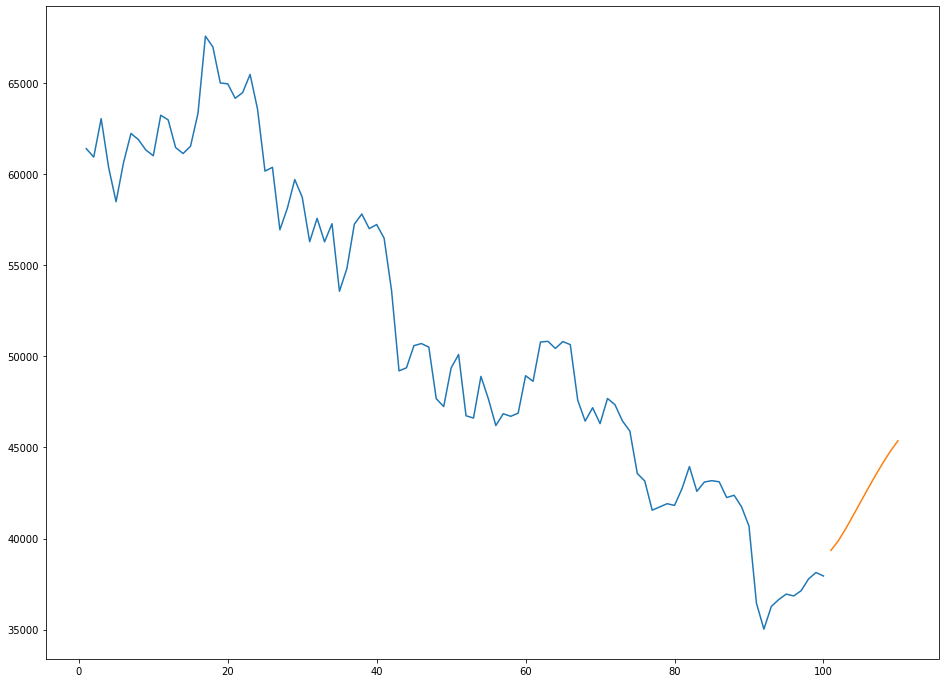

In [ ]:
plt.figure(figsize=(16,12))
plt.plot(day_new,scaler.inverse_transform(scaled_btc[len(scaled_btc)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))